In [173]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score,recall_score,f1_score,auc,roc_curve
#Supress the warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
#This will help us to display all the columns of the data set
pd.set_option('display.max_columns',None)

In [3]:
data = pd.read_csv('XYZCorp_LendingData.txt',sep='\t',index_col=0)
#We will create a copy of the dataframe now
data_copy1 = data.copy()

In [4]:
#Lets check the info of the dataset
data_copy1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 855969 entries, 1077501 to 36271262
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    855969 non-null  int64  
 1   loan_amnt                    855969 non-null  float64
 2   funded_amnt                  855969 non-null  float64
 3   funded_amnt_inv              855969 non-null  float64
 4   term                         855969 non-null  object 
 5   int_rate                     855969 non-null  float64
 6   installment                  855969 non-null  float64
 7   grade                        855969 non-null  object 
 8   sub_grade                    855969 non-null  object 
 9   emp_title                    806526 non-null  object 
 10  emp_length                   812908 non-null  object 
 11  home_ownership               855969 non-null  object 
 12  annual_inc                   855969 non-null  floa

In [5]:
#Creating the function to seprate the month and year. 
def month(var): #function to seprate month from the datetime variables
    return var.split('-')[0]
def year(var): #function to seprate year from the datetime variables
    return var.split('-')[1]

In [6]:
data_copy1['issue_month'] = data_copy1['issue_d'].apply(month) #using the apply function
data_copy1['issue_year'] = data_copy1['issue_d'].apply(year) #using the apply function

In [7]:
data_copy1['ealiset_cr_month'] = data_copy1['earliest_cr_line'].apply(month)
data_copy1['ealiset_cr_year'] = data_copy1['earliest_cr_line'].apply(year)
data_copy1.drop('earliest_cr_line',axis=1,inplace=True) #droping the variable

In [8]:
#We will remove two records where annual income is 0
data_copy1.drop([66415476,65199509],axis=0,inplace=True) #Droping two records

Now we will check null values

In [9]:
#Creating the data frame to check the sum of null values 
null_values_df = pd.DataFrame({'Sum':data_copy1.isnull().sum(),'Percent':data_copy1.isnull().mean()*100})
null_values_df[null_values_df['Sum']>0] 

,Sum,Percent
emp_title,49441,5.776040
emp_length,43059,5.030451
desc,734155,85.769078
title,33,0.003855
mths_since_last_delinq,439811,51.381771
mths_since_last_record,724783,84.674176
revol_util,446,0.052105
last_pymnt_d,8862,1.035320
next_pymnt_d,252971,29.553826
last_credit_pull_d,50,0.005841


There are so many variables which are having more than 50% null values. We will remove them.

In [10]:
#Using the index to drop variables where missing values are more than 50%
data_copy1.drop(null_values_df[null_values_df['Percent']>50].index,axis=1,inplace=True) 

We will again create the dataframe where we will check the variables with the null values 

In [11]:
#Create the dataframe to check Sum and Percent of null values
null_values_df = pd.DataFrame({'Sum':data_copy1.isnull().sum(),'Percent':data_copy1.isnull().mean()*100})
null_values_df[null_values_df['Sum']>0]

,Sum,Percent
emp_title,49441,5.776040
emp_length,43059,5.030451
title,33,0.003855
revol_util,446,0.052105
last_pymnt_d,8862,1.035320
next_pymnt_d,252971,29.553826
last_credit_pull_d,50,0.005841
collections_12_mths_ex_med,56,0.006542
tot_coll_amt,67313,7.863971
tot_cur_bal,67313,7.863971


In [13]:
data_copy1['term']= data_copy1['term'].str.split(" ").str[1] #Seprating the first part of the text that is 36 and 60 
data_copy1['term'] = data_copy1['term'].astype('int64') #Converting the text into integers 

Now we will check why the emp_length is in object, not in int64 type

In [14]:
data_copy1['emp_length'].value_counts()

10+ years    282090
2 years       75986
< 1 year      67597
3 years       67392
1 year        54855
5 years       53812
4 years       50643
7 years       43204
8 years       42421
6 years       41446
9 years       33462
Name: emp_length, dtype: int64

In [15]:
#Replacing the 10+ years with 10 years
data_copy1['emp_length'] = np.where(data_copy1['emp_length']=='10+ years','10 years',data_copy1['emp_length'])
#Replacing the < 1 year with 0 year
data_copy1['emp_length'] = np.where(data_copy1['emp_length']=='< 1 year','0 year',data_copy1['emp_length'])
data_copy1['emp_length'].fillna('0 year',inplace=True) #Filling the null values with  0
data_copy1['emp_length'] = data_copy1['emp_length'].str.split(" ",expand=True) #Seprating the numerical part
data_copy1['emp_length'] = data_copy1['emp_length'].astype('float64') #Converting the object type to float type

In [16]:
#Filling null of 'last_credit_pull_d','last_pymnt_d','next_pymnt_d'
for i in ['last_credit_pull_d','last_pymnt_d','next_pymnt_d']:
    med = data_copy1[i].mode()[0]
    data_copy1[i].fillna(med,inplace=True)

In [17]:
data_copy1['last_credit_pull_d_month'] = data_copy1['last_credit_pull_d'].apply(month)
data_copy1['last_credit_pull_d_year'] = data_copy1['last_credit_pull_d'].apply(year)
data_copy1['last_pymnt_d_month'] = data_copy1['last_pymnt_d'].apply(month)
data_copy1['last_pymnt_d_year'] = data_copy1['last_pymnt_d'].apply(year)
data_copy1['next_pymnt_d_month'] = data_copy1['next_pymnt_d'].apply(month)
data_copy1['next_pymnt_d_year'] = data_copy1['next_pymnt_d'].apply(year)

data_copy1.drop(['last_pymnt_d','next_pymnt_d', 'last_credit_pull_d'],axis=1,inplace=True)

In [18]:
#We will check the categories in emp_title
data_copy1['emp_title'].value_counts()

Teacher                      12965
Manager                      10821
Registered Nurse              5341
RN                            5182
Owner                         5157
                             ...  
Director, Loss Control           1
Compliance Senior Analyst        1
pyschologist                     1
SVP, Partner                     1
Unit Supply SGT                  1
Name: emp_title, Length: 290912, dtype: int64

There are 290912 cateogries for employment title but this might play a role in loan default so we will keep this variables and clean this

In [19]:
#We will fill null values with mode
data_copy1['emp_title'].fillna(data_copy1['emp_title'].mode()[0],inplace=True)

In [20]:
#We will now clean emp_title
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='registered nurse','Registered Nurse',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Branch Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Program Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Store Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Account Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Sales Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Operations Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='General Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Office Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Project Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='IT Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Registered nurse','Registered Nurse',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='nurse','Nurse',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Truck driver','Truck Driver',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='truck driver','Truck Driver',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Accounting Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='District Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Product Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='HR Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='General Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Finance Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Case Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='store Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='general Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Regional Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Regional Sales Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Property Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='owner','Owner',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='OWNER','Owner',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='cook','Cook',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Chef','Cook',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='welder','Welder',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='welder','Welder',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='teacher','Teacher',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='sales','Sales',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='supervisor','Supervisor',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='driver','Driver',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Business Analyst','Analyst',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='technician','Technician',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Senior Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Business Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Marketing Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Production Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='MANAGER','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Service Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='office manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='general manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='store manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='machine operator','Operator',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='operator','Operator',data_copy1['emp_title'])

In [21]:
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Administrative Assistant','Assistant',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Executive Assistant','Assistant',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Legal Assistant','Assistant',data_copy1['emp_title']) 
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='engineer','Engineer',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Police officer','Police Officer',data_copy1['emp_title']) 
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='mechanic','Mechanic',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='sales manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Office manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Store manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Area manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Warehouse manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Territory manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Systems Analyst','Analyst',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Financial Analyst','Analyst',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Rn','RN',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='rn','RN',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Plant manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Business Development manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Warehouse Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Area Manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='president','President',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='laborer','Laborer',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='SALES','Sales',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Data Analyst','Analyst',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Project manager','Manager',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Operations Supervisor','SUPERVISOR',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Production Supervisor','SUPERVISOR',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Program Analyst','Analyst',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='tech','Tech',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Truck driver','Truck Driver',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Machinist','Mechanic',data_copy1['emp_title'])
data_copy1['emp_title'] = np.where(data_copy1['emp_title']=='Operato','Operator',data_copy1['emp_title'])

In [22]:
#We will now merge all the categories which are having less than 600 value count into single category
minimum_count = 600 #Set a minimum count
counts = data_copy1['emp_title'].value_counts()
to_combine = counts[counts<minimum_count].index #Get a list of values to combine
mask = data_copy1['emp_title'].isin(to_combine) # Get mask of values to combine
data_copy1['employment_title'] = data_copy1['emp_title'] # Create a new column that will store combined values
data_copy1.loc[mask,'employment_title'] = 'Other' #Sets value of the columns to combine to `Other`.

In [23]:
#We will now drop emp_title variables
data_copy1.drop('emp_title',axis=1,inplace=True)

In [24]:
#We will now check for the revol_util
data_copy1['revol_util']

id
1077501     83.7
1077430      9.4
1077175     98.5
1076863     21.0
1075358     53.9
            ... 
36371250    82.1
36441262    84.5
36271333    61.3
36490806    30.6
36271262    79.8
Name: revol_util, Length: 855967, dtype: float64

Text(0.5, 1.0, 'Count of Revolving Utilization Rate')

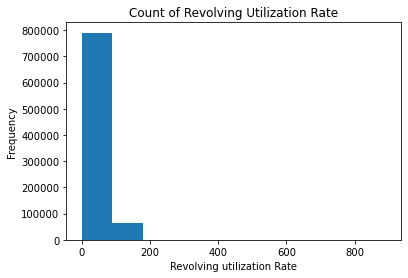

In [25]:
plt.hist(data_copy1['revol_util'])
plt.xlabel('Revolving utilization Rate')
plt.ylabel('Frequency')
plt.title('Count of Revolving Utilization Rate')

In [26]:
data_copy1['revol_util'].describe()

count    855521.000000
mean         55.019363
std          23.811585
min           0.000000
25%          37.600000
50%          55.900000
75%          73.500000
max         892.300000
Name: revol_util, dtype: float64

In [27]:
#We will replace the null values with the median 
data_copy1['revol_util'].fillna(data_copy1['revol_util'].median(), inplace=True)

In [28]:
#WE will now check collections_12_mths_ex_med
data_copy1['collections_12_mths_ex_med']

id
1077501     0.0
1077430     0.0
1077175     0.0
1076863     0.0
1075358     0.0
           ... 
36371250    0.0
36441262    0.0
36271333    0.0
36490806    1.0
36271262    0.0
Name: collections_12_mths_ex_med, Length: 855967, dtype: float64

(array([8.55086e+05, 7.89000e+02, 2.90000e+01, 3.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

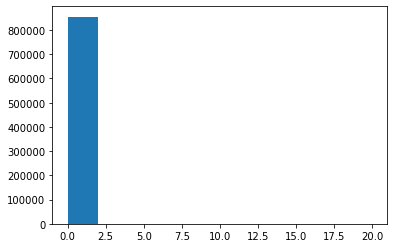

In [29]:
plt.hist(data_copy1['collections_12_mths_ex_med'])

In [30]:
data_copy1['collections_12_mths_ex_med'].describe()

count    855911.000000
mean          0.014230
std           0.133712
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: collections_12_mths_ex_med, dtype: float64

In [31]:
#We will replace the Null values with median
data_copy1['collections_12_mths_ex_med'].fillna(data_copy1['collections_12_mths_ex_med'].median(), inplace=True)

In [32]:
#We will now check tot_coll_amt
data_copy1['tot_coll_amt']

id
1077501     NaN
1077430     NaN
1077175     NaN
1076863     NaN
1075358     NaN
           ... 
36371250    0.0
36441262    0.0
36271333    0.0
36490806    0.0
36271262    0.0
Name: tot_coll_amt, Length: 855967, dtype: float64

(array([7.88653e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([      0. ,  915254.5, 1830509. , 2745763.5, 3661018. , 4576272.5,
        5491527. , 6406781.5, 7322036. , 8237290.5, 9152545. ]),
 <a list of 10 Patch objects>)

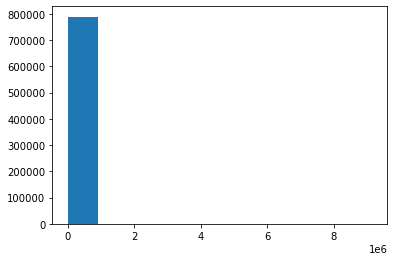

In [33]:
plt.hist(data_copy1['tot_coll_amt'])

In [34]:
data_copy1['tot_coll_amt'].describe()

count    7.886540e+05
mean     2.254135e+02
std      1.048946e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

In [35]:
#We will replace the null of tot_coll_amt, tot_cur_bal, total_rev_hi_lim with median
data_copy1['total_rev_hi_lim'].fillna(data_copy1['total_rev_hi_lim'].median(),inplace=True)
data_copy1['tot_coll_amt'].fillna(data_copy1['tot_coll_amt'].median(),inplace=True)
data_copy1['tot_cur_bal'].fillna(data_copy1['tot_cur_bal'].median(),inplace=True)

In [36]:
#We will now remove the unwanted variables 
unneccesary_variables = ['member_id','sub_grade','pymnt_plan','title','zip_code','initial_list_status'
                        ,'policy_code']
data_copy1.drop(unneccesary_variables,axis=1,inplace=True)

In [37]:
#We will now convert the data type of issue_d to datetime
data_copy1['issue_d'] = pd.to_datetime(data_copy1['issue_d'])

In [38]:
data_copy1['last_pymnt_d_year'] =2016 - data_copy1['last_pymnt_d_year'].astype('int64')
data_copy1['issue_year'] = 2016 - data_copy1['issue_year'].astype('int64')
data_copy1['next_pymnt_d_year'] = 2016-data_copy1['next_pymnt_d_year'].astype('int64')
data_copy1['last_credit_pull_d_year'] = 2016- data_copy1['last_credit_pull_d_year'].astype('int64')
data_copy1['ealiset_cr_year'] = 2016 - data_copy1['ealiset_cr_year'].astype('int64')

## Label Encoding

In [40]:
label = LabelEncoder()#Creating the object of LabelEncoder

In [41]:
data_copy1['grade'] = label.fit_transform(data_copy1['grade']) #Label Encoding

In [42]:
#We will do some changes in home_ownership 
#Replacing the NONE category to OTHER
data_copy1['home_ownership'] = np.where(data_copy1['home_ownership']=='NONE','OTHER',data_copy1['home_ownership'])
#Replacing the ANY category to OTHER
data_copy1['home_ownership'] = np.where(data_copy1['home_ownership']=='ANY','OTHER',data_copy1['home_ownership'])
data_copy1['home_ownership'] = label.fit_transform(data_copy1['home_ownership']) #Label Encoding

In [43]:
data_copy1['verification_status'] = label.fit_transform(data_copy1['verification_status']) #Label Encoding

In [44]:
data_copy1['purpose'] = label.fit_transform(data_copy1['purpose']) #Label Encoding

In [45]:
data_copy1['addr_state'] = label.fit_transform(data_copy1['addr_state']) #Label Encoding

In [46]:
data_copy1['employment_title'] = label.fit_transform(data_copy1['employment_title']) #Label Encoding

In [47]:
data_copy1['issue_month'] = label.fit_transform(data_copy1['issue_month']) #Label Encoding
data_copy1['next_pymnt_d_month'] = label.fit_transform(data_copy1['next_pymnt_d_month']) #Label Encoding
data_copy1['last_credit_pull_d_month'] = label.fit_transform(data_copy1['last_credit_pull_d_month']) #Label Encoding
data_copy1['last_pymnt_d_month'] = label.fit_transform(data_copy1['last_credit_pull_d_month']) #Label Encoding

In [48]:
data_copy1['ealiset_cr_month'] = label.fit_transform(data_copy1['ealiset_cr_month']) #Label Encoding
data_copy1['application_type'] = label.fit_transform(data_copy1['application_type']) #Label Encoding

### We will now remove some of the variables on the basis of correlation

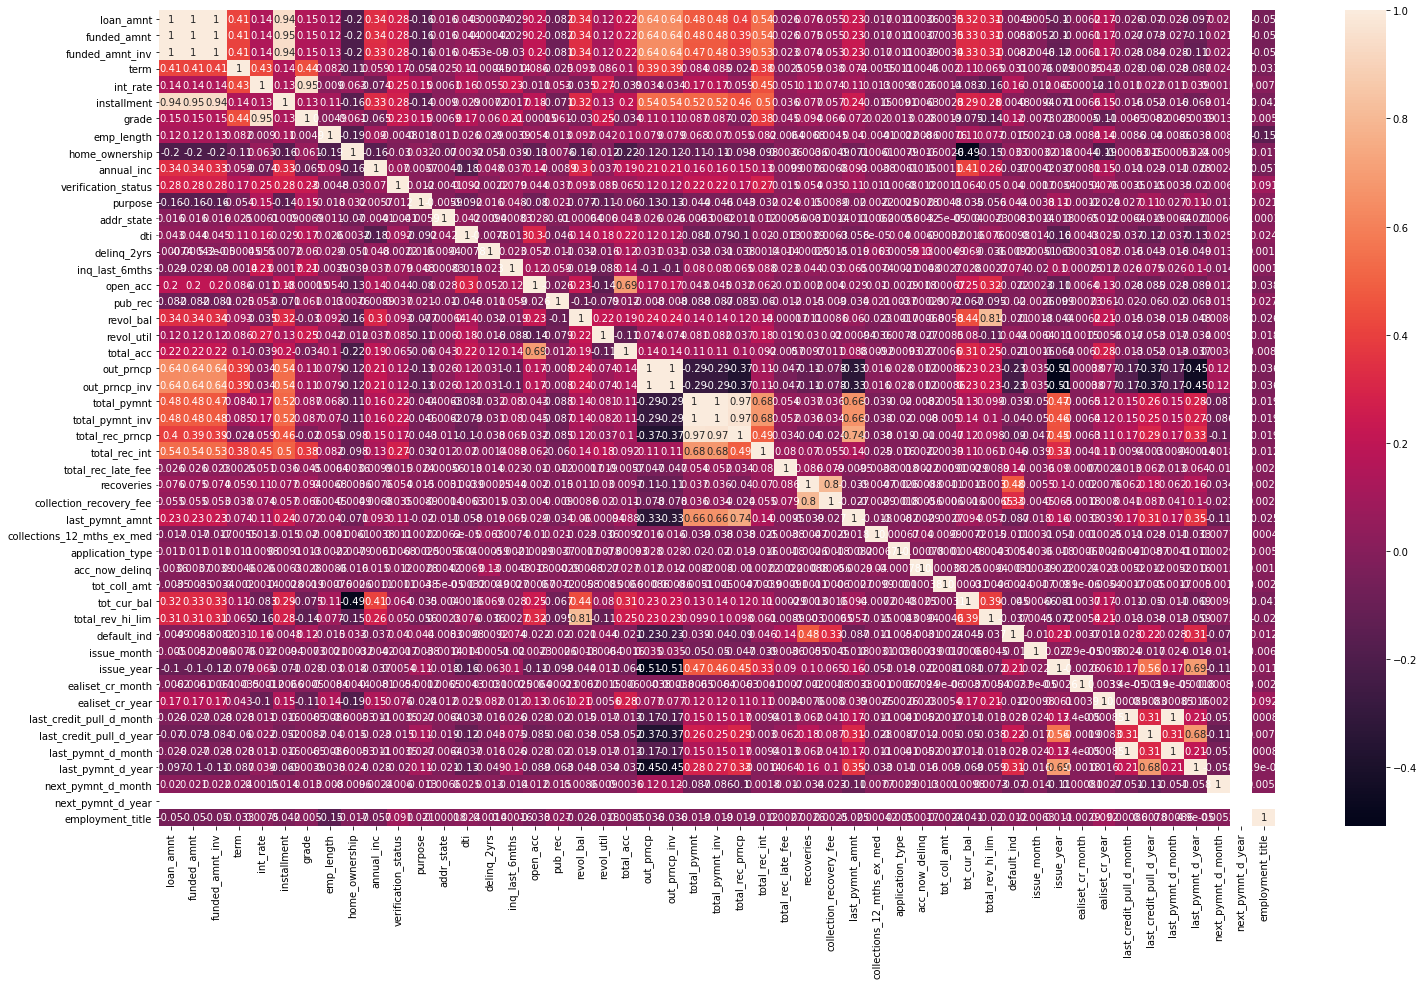

In [49]:
cor = data_copy1.corr() #Setting the correlation
plt.figure(figsize=(25,15)) #Figure size
sns.heatmap(cor,annot=True) #Drawing heatmap

In [187]:
data_copy1.corr()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp_inv,total_pymnt,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind,issue_month,issue_year,ealiset_cr_month,ealiset_cr_year,last_credit_pull_d_month,last_credit_pull_d_year,last_pymnt_d_year,next_pymnt_d_month,employment_title
loan_amnt,1.000000,0.411192,0.142966,0.124572,-0.197080,0.335209,0.281637,-0.156934,0.015799,0.042751,-0.000735,-0.028928,0.198926,-0.082199,0.337489,0.119585,0.222085,0.639785,0.479612,0.537586,0.025966,0.075513,0.055135,0.233596,-0.017034,0.011104,0.003572,-0.003539,0.324615,0.305258,-0.004907,-0.005002,-0.099626,-0.006199,0.169813,-0.025973,-0.070051,-0.096882,0.020495,-0.050262
term,0.411192,1.000000,0.427412,0.081561,-0.111209,0.059055,0.168262,-0.053806,0.024666,0.105640,-0.000450,-0.001365,0.086171,-0.025198,0.093388,0.085875,0.101664,0.391189,0.083997,0.383917,0.002509,0.059381,0.038079,0.073894,-0.005463,0.011095,0.004606,-0.001987,0.110602,0.064663,0.031377,0.007552,-0.079288,0.000352,0.043383,-0.028125,-0.060352,-0.087269,0.024074,-0.033156
int_rate,0.142966,0.427412,1.000000,0.009015,0.063206,-0.073824,0.250942,0.149720,0.006098,0.161418,0.055401,0.231705,-0.011090,0.052596,-0.035344,0.271613,-0.039481,0.033788,0.173388,0.446518,0.050743,0.110848,0.074360,0.107347,0.012846,0.009822,0.026476,0.001370,-0.082750,-0.156496,0.155037,-0.011919,0.064988,-0.000123,-0.103937,0.011028,0.022421,0.039057,0.001542,0.007462
emp_length,0.124572,0.081561,0.009015,1.000000,-0.189322,0.089903,-0.004817,-0.018149,0.010643,0.025637,0.028555,-0.003857,0.053920,0.012740,0.091852,0.041848,0.102376,0.078599,0.068246,0.081981,-0.006352,0.006804,0.004522,0.040249,-0.004107,-0.002171,0.008566,-0.000761,0.114679,0.076895,-0.014996,0.002149,-0.029670,-0.008421,0.141209,-0.008642,-0.039996,-0.037828,0.008011,-0.149766
home_ownership,-0.197080,-0.111209,0.063206,-0.189322,1.000000,-0.157776,-0.030116,0.031576,-0.069963,0.003232,-0.051177,-0.038594,-0.129394,0.007606,-0.161148,-0.011649,-0.219439,-0.118982,-0.108745,-0.097741,0.003636,-0.003594,-0.004864,-0.071041,0.006105,-0.007856,-0.016052,-0.002646,-0.488241,-0.150742,0.032976,0.000318,0.017634,0.004425,-0.192551,-0.000530,0.014674,0.024196,-0.009622,-0.016508
annual_inc,0.335209,0.059055,-0.073824,0.089903,-0.157776,1.000000,0.069911,0.005737,-0.004142,-0.176518,0.047752,0.037252,0.139427,-0.008910,0.298568,0.036744,0.188649,0.211592,0.163224,0.130365,0.009863,0.007613,0.006805,0.092661,-0.003791,-0.006097,0.014877,0.001148,0.410406,0.264034,-0.037067,-0.004155,-0.036782,-0.008068,0.145591,-0.011300,-0.023037,-0.028137,0.002428,-0.057232
verification_status,0.281637,0.168262,0.250942,-0.004817,-0.030116,0.069911,1.000000,0.011645,-0.004095,0.092293,-0.002192,0.078615,0.044075,0.036747,0.093095,0.084857,0.064692,0.119587,0.216035,0.274927,0.015373,0.053798,0.035255,0.105946,0.011410,0.006801,0.011970,0.001117,0.063991,0.050460,0.039584,-0.001749,0.005447,-0.005419,0.075730,-0.003543,-0.014886,-0.019685,0.005988,0.091367
purpose,-0.156934,-0.053806,0.149720,-0.018149,0.031576,0.005737,0.011645,1.000000,-0.005896,-0.091640,0.016354,0.048347,-0.080394,0.021079,-0.077227,-0.112712,-0.059926,-0.129856,-0.043954,-0.031861,0.023587,0.015085,0.008937,-0.019588,0.002204,-0.002483,0.002769,0.004758,-0.034839,-0.056255,0.043574,-0.003789,0.112190,-0.001238,-0.024288,0.027300,0.111460,0.109394,-0.012523,0.021211
addr_state,0.015799,0.024666,0.006098,0.010643,-0.069963,-0.004142,-0.004095,-0.005896,1.000000,0.042194,0.009417,0.000827,0.028261,-0.010332,-0.000645,0.006031,0.042582,0.025668,-0.006312,0.011943,0.000557,-0.003123,-0.001386,-0.010958,0.006170,0.000559,0.004226,-0.000035,-0.003952,0.002254,-0.008271,-0.001417,-0.018466,0.006486,0.012142,-0.006

In [50]:
#Droping the variables which are correlated 
correlated_variables_removed = ['funded_amnt','funded_amnt_inv','total_pymnt_inv','total_rec_prncp','next_pymnt_d_year'
                               ,'last_pymnt_d_month','out_prncp','installment','grade']
data_copy1.drop(correlated_variables_removed,axis=1,inplace=True)

In [51]:
#Train data set
X_train = data_copy1.loc[data_copy1['issue_d']<'2015-06-01']
y_train = X_train['default_ind']
X_train.drop(['issue_d','default_ind'],axis=1,inplace=True)
#Test Data set
X_test = data_copy1.loc[data_copy1['issue_d']>='2015-06-01']
y_test = X_test['default_ind']
X_test.drop(['issue_d','default_ind'],axis=1,inplace=True)

In [52]:
#Check the shape of all the data set
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((598978, 39), (256989, 39), (598978,), (256989,))

#### We will now create a function to store the values to compare accuracy,precision,recal,errors of every model


In [53]:
def metric_for_comparison(actual_values, predicted_values):
    list_for_values = []
    cfm = confusion_matrix(actual_values,predicted_values)
    #We need accuracy score in the table we want to compare
    acc = round(accuracy_score(actual_values,predicted_values),4)
    list_for_values.append(acc)
    print('\nAccuracy of Model :',acc)
    
    
    # Precision value of class 1
    pr = round(precision_score(actual_values,predicted_values),4)
    list_for_values.append(pr)
    
    # Recall value of class 1
    re = round(recall_score(actual_values,predicted_values),4)
    list_for_values.append(re)
    
    # F1-score value of class 1
    f1 = round(f1_score(actual_values,predicted_values),4)
    list_for_values.append(f1)
    
    # Type I error value
    list_for_values.append(cfm[0,1])
    
    # Type II error value
    list_for_values.append(cfm[1,0])
    
    # Total error value 
    list_for_values.append(cfm[0,1]+cfm[1,0])
    
    return list_for_values

#### We will create dataframe to store result

In [161]:
result = pd.DataFrame(columns = ['Algorithm_Use','Overall Accuracy','Precision Value','Recall Value','F1-Score',
                                 'Type I Error','Type II Error', 'Total Error'])

result['Algorithm_Use'] = ['Logistic Regression', 'Decision Tree', 'Tuned Decision Tree',
                       'Random Forest','Tuned Random Forest','KNN','SVC','XG Boost']

result.set_index('Algorithm_Use', inplace = True)

#### We will create dataframe to store predicted values

In [56]:
prediction = pd.DataFrame()
prediction['Actual Values'] = y_test

## Logistic Regression

In [57]:
logistic = LogisticRegression()
logistic.fit(X_train,y_train)

LogisticRegression()

#### On test Data

In [59]:
y_pred_logistic = logistic.predict(X_test)

In [162]:
print(confusion_matrix(y_test,y_pred_logistic))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_logistic))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_logistic))

output = metric_for_comparison(y_test,y_pred_logistic)
prediction['y_pred_logistic'] = y_pred_logistic
var = 0
for col in result.columns:
    result.loc['Logistic Regression',col] = output[var]
    var += 1

[[256678      0]
 [    64    247]]
-----------------------------------------------
0.9997509621034363
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256678
           1       1.00      0.79      0.89       311

    accuracy                           1.00    256989
   macro avg       1.00      0.90      0.94    256989
weighted avg       1.00      1.00      1.00    256989


Accuracy of Model : 0.9998


#### On train Data

In [63]:
y_pred_logistic_train = logistic.predict(X_train)

In [64]:
print(confusion_matrix(y_train,y_pred_logistic_train))
print("-----------------------------------------------")
print(accuracy_score(y_train,y_pred_logistic_train))
print('-----------------------------------------------')
print(classification_report(y_train,y_pred_logistic_train))

[[552254    568]
 [  3306  42850]]
-----------------------------------------------
0.9935323167128008
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    552822
           1       0.99      0.93      0.96     46156

    accuracy                           0.99    598978
   macro avg       0.99      0.96      0.98    598978
weighted avg       0.99      0.99      0.99    598978



## Decision Tree

In [65]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier()

#### On test Data

In [66]:
y_pred_decision_tree = decision_tree.predict(X_test)

In [163]:
print(confusion_matrix(y_test,y_pred_decision_tree))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_decision_tree))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_decision_tree))

output = metric_for_comparison(y_test,y_pred_decision_tree)
prediction['y_pred_decision_tree'] = y_pred_decision_tree
var = 0
for col in result.columns:
    result.loc['Decision Tree',col] = output[var]
    var += 1

[[220337  36341]
 [    19    292]]
-----------------------------------------------
0.8585153450147671
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    256678
           1       0.01      0.94      0.02       311

    accuracy                           0.86    256989
   macro avg       0.50      0.90      0.47    256989
weighted avg       1.00      0.86      0.92    256989


Accuracy of Model : 0.8585


In [89]:
decision_tree = DecisionTreeClassifier()
#performing kfold  cross validation
from sklearn.model_selection import KFold
kfold_cv = KFold(n_splits=5, random_state=1)
from sklearn.model_selection import cross_val_score
kfold_cv_result = cross_val_score(estimator=decision_tree,X=X_train,y=y_train,cv=kfold_cv)
print(kfold_cv_result)
print(kfold_cv_result.mean())

[0.97846339 0.97861364 0.99043374 0.9873367  0.98967403]
0.9849042989928323


In [90]:
#model tunning
for train_value,test_value in kfold_cv.split(X_train):
    decision_tree.fit(X_train.iloc[train_value],y_train.iloc[train_value]).predict(X_train.iloc[test_value])
    
y_pred_decision_cross_val = decision_tree.predict(X_test)

In [91]:
print(confusion_matrix(y_test,y_pred_decision_cross_val))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_decision_cross_val))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_decision_cross_val))


[[240594  16084]
 [    20    291]]
-----------------------------------------------
0.9373358392771675
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    256678
           1       0.02      0.94      0.03       311

    accuracy                           0.94    256989
   macro avg       0.51      0.94      0.50    256989
weighted avg       1.00      0.94      0.97    256989



## Now we will tune the Decision Tree Model

In [93]:
parameter = {'criterion':['gini','entropy'],'max_depth':range(1,15),'min_samples_split':range(1,10),
             'min_samples_leaf':range(1,8),'splitter':['best','random']}

In [94]:
random_search = RandomizedSearchCV(estimator=decision_tree,param_distributions=parameter,cv=5,n_jobs=-1,
                                   n_iter=20)

In [95]:
random_search.fit(X_train.iloc[train_value],y_train.iloc[train_value])

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 15),
                                        'min_samples_leaf': range(1, 8),
                                        'min_samples_split': range(1, 10),
                                        'splitter': ['best', 'random']})

In [96]:
best_parameters = random_search.best_params_
print(best_parameters)

{'splitter': 'random', 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_depth': 11, 'criterion': 'entropy'}


In [97]:
decision_tree= DecisionTreeClassifier(min_samples_split=7,max_depth=11,min_samples_leaf=7,criterion='entropy',splitter='random')
decision_tree.fit(X_train.iloc[train_value],y_train.iloc[train_value])

DecisionTreeClassifier(criterion='entropy', max_depth=11, min_samples_leaf=7,
                       min_samples_split=7, splitter='random')

In [98]:
y_pred_decision_tree_tuned = decision_tree.predict(X_test)

In [164]:
print(confusion_matrix(y_test,y_pred_decision_tree_tuned))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_decision_tree_tuned))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_decision_tree_tuned))

output = metric_for_comparison(y_test,y_pred_decision_tree_tuned)
prediction['y_pred_decision_tree_tuned'] = y_pred_decision_tree_tuned
var = 0
for col in result.columns:
    result.loc['Tuned Decision Tree',col] = output[var]
    var += 1

[[256535    143]
 [    64    247]]
-----------------------------------------------
0.9991945180533018
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256678
           1       0.63      0.79      0.70       311

    accuracy                           1.00    256989
   macro avg       0.82      0.90      0.85    256989
weighted avg       1.00      1.00      1.00    256989


Accuracy of Model : 0.9992


## Random Classifier

In [103]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train,y_train)

RandomForestClassifier()

#### On Test Data

In [104]:
y_pred_random_forest = random_forest.predict(X_test)

In [165]:
print(confusion_matrix(y_test,y_pred_random_forest))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_random_forest))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_random_forest))

output = metric_for_comparison(y_test,y_pred_random_forest)
prediction['y_pred_random_forest'] = y_pred_random_forest
var = 0
for col in result.columns:
    result.loc['Random Forest',col] = output[var]
    var += 1

[[231376  25302]
 [     8    303]]
-----------------------------------------------
0.9015132943433376
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    256678
           1       0.01      0.97      0.02       311

    accuracy                           0.90    256989
   macro avg       0.51      0.94      0.49    256989
weighted avg       1.00      0.90      0.95    256989


Accuracy of Model : 0.9015


In [109]:
kfold_cv = KFold(n_splits=5, random_state=1)

kfold_cv_result = cross_val_score(estimator=random_forest,X=X_train,y=y_train,cv=kfold_cv)
print(kfold_cv_result)
print(kfold_cv_result.mean())

[0.9946075  0.9930966  0.99690307 0.99691139 0.99772111]
0.9958479325394791


In [110]:
#model tunning
for train_value,test_value in kfold_cv.split(X_train):
    random_forest.fit(X_train.iloc[train_value],y_train.iloc[train_value]).predict(X_train.iloc[test_value])
    
y_pred_rf_cross_val = random_forest.predict(X_test)

In [111]:
print(confusion_matrix(y_test,y_pred_rf_cross_val))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_rf_cross_val))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_rf_cross_val))

[[238593  18085]
 [    17    294]]
-----------------------------------------------
0.9295611874438205
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    256678
           1       0.02      0.95      0.03       311

    accuracy                           0.93    256989
   macro avg       0.51      0.94      0.50    256989
weighted avg       1.00      0.93      0.96    256989



#### Tunned Random Forest

In [112]:
parameter = {'criterion':['gini','entropy'],'max_depth':range(2,15),'min_samples_split':range(1,10),
             'min_samples_leaf':range(1,10)}

In [113]:
random_search = RandomizedSearchCV(estimator=random_forest,param_distributions=parameter,cv=5,n_jobs=-1,
                                   n_iter=20)

In [114]:
random_search.fit(X_train.iloc[train_value],y_train.iloc[train_value])

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 15),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(1, 10)})

In [115]:
best_parameter = random_search.best_params_
print(best_parameter)

{'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 12, 'criterion': 'entropy'}


In [116]:
random_forest = RandomForestClassifier(min_samples_split=2,min_samples_leaf=4,max_depth=12,criterion='entropy')
random_forest.fit(X_train.iloc[train_value],y_train.iloc[train_value])

RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_leaf=4)

In [117]:
y_pred_rf_tuned = random_forest.predict(X_test)

In [166]:
print(confusion_matrix(y_test,y_pred_rf_tuned))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_rf_tuned))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_rf_tuned))

output = metric_for_comparison(y_test,y_pred_rf_tuned)
prediction['y_pred_rf_tuned'] = y_pred_rf_tuned
var = 0
for col in result.columns:
    result.loc['Tuned Random Forest',col] = output[var]
    var += 1

[[248451   8227]
 [    58    253]]
-----------------------------------------------
0.9677612660464067
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    256678
           1       0.03      0.81      0.06       311

    accuracy                           0.97    256989
   macro avg       0.51      0.89      0.52    256989
weighted avg       1.00      0.97      0.98    256989


Accuracy of Model : 0.9678


## KNN

In [122]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

#### On Train Data

In [123]:
y_pred_knn = knn.predict(X_test)

In [134]:
result.drop('Tunned KNN',axis=0,inplace=True)

In [167]:
print(confusion_matrix(y_test,y_pred_knn))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_knn))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_knn))

output = metric_for_comparison(y_test,y_pred_knn)
prediction['y_pred_knn'] = y_pred_knn
var = 0
for col in result.columns:
    result.loc['KNN',col] = output[var]
    var += 1

[[256594     84]
 [   141    170]]
-----------------------------------------------
0.9991244761448934
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256678
           1       0.67      0.55      0.60       311

    accuracy                           1.00    256989
   macro avg       0.83      0.77      0.80    256989
weighted avg       1.00      1.00      1.00    256989


Accuracy of Model : 0.9991


## SVC

In [137]:
svc = SVC()
svc.fit(X_train,y_train)

SVC()

In [138]:
y_pred_svc_train = svc.predict(X_test)

In [168]:
print(confusion_matrix(y_test,y_pred_svc_train))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_svc_train))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_svc_train))

output = metric_for_comparison(y_test,y_pred_svc_train)
prediction['y_pred_svc'] = y_pred_svc_train
var = 0
for col in result.columns:
    result.loc['SVC',col] = output[var]
    var += 1

[[256593     85]
 [    75    236]]
-----------------------------------------------
0.9993774052585909
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256678
           1       0.74      0.76      0.75       311

    accuracy                           1.00    256989
   macro avg       0.87      0.88      0.87    256989
weighted avg       1.00      1.00      1.00    256989


Accuracy of Model : 0.9994


## XG Boost

In [141]:
xg_boost = GradientBoostingClassifier()
xg_boost.fit(X_train,y_train)

GradientBoostingClassifier()

In [144]:
y_pred_xg = xg_boost.predict(X_test)

In [169]:
print(confusion_matrix(y_test,y_pred_xg))
print("-----------------------------------------------")
print(accuracy_score(y_test,y_pred_xg))
print('-----------------------------------------------')
print(classification_report(y_test,y_pred_xg))

output = metric_for_comparison(y_test,y_pred_xg)
prediction['y_pred_xg'] = y_pred_xg
var = 0
for col in result.columns:
    result.loc['XG Boost',col] = output[var]
    var += 1

[[214236  42442]
 [    17    294]]
-----------------------------------------------
0.8347828117156766
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    256678
           1       0.01      0.95      0.01       311

    accuracy                           0.83    256989
   macro avg       0.50      0.89      0.46    256989
weighted avg       1.00      0.83      0.91    256989


Accuracy of Model : 0.8348


In [170]:
result

,Overall Accuracy,Precision Value,Recall Value,F1-Score,Type I Error,Type II Error,Total Error
Algorithm_Use,,,,,,,
Logistic Regression,0.9998,1,0.7942,0.8853,0,64,64
Decision Tree,0.8585,0.008,0.9389,0.0158,36341,19,36360
Tuned Decision Tree,0.9992,0.6333,0.7942,0.7047,143,64,207
Random Forest,0.9015,0.0118,0.9743,0.0234,25302,8,25310
Tuned Random Forest,0.9678,0.0298,0.8135,0.0576,8227,58,8285
KNN,0.9991,0.6693,0.5466,0.6018,84,141,225
SVC,0.9994,0.7352,0.7588,0.7468,85,75,160
XG Boost,0.8348,0.0069,0.9453,0.0137,42442,17,42459


#### Function for the AUC

In [184]:
def AUC_value(value):
    fp = []
    tp = []
    auc_v = []

    for i in value.columns[0:]:
        f,t,z = roc_curve(value['Actual Values'], value[i])
        a = round(auc(f,t),6)
        fp.append(f)
        tp.append(t)
        auc_v.append(a)
        
    auc_v1 = [round(i*100,2) for i in auc_v]
    auc_v1 = list(map("{}%".format, auc_v1))
    return auc_v1,fp,tp

#### Function for Plot of AUC-ROC Curve

In [185]:
def plot(fp,tp,auc_val):

    plt.figure(figsize = (10,6)) #Setting the plot size
    plt.title('AUC-ROC CURVE', fontsize = 18)  #Setting the title of the Plot
    plt.plot(fp[0],tp[0], label = str('Logistic Regression'+' '+str(auc_val[0]))) #Ploting Logistic Regresssion
    plt.plot(fp[2],tp[2], label = str('Decision Tree'+' '+str(auc_val[2]))) #Plotting Decision Tree
    plt.plot(fp[3],tp[3], label = str('Tuned Decision Tree'+' '+str(auc_val[3]))) #Plotting Tuned Decision Tree
    plt.plot([0,1],[0,1],'r--')

    plt.legend(loc = 0, fontsize = 13)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)

    plt.xticks(np.arange(0,1.1,0.1), fontsize = 12)
    plt.yticks(np.arange(0,1.1,0.1), fontsize = 12)

    plt.show()

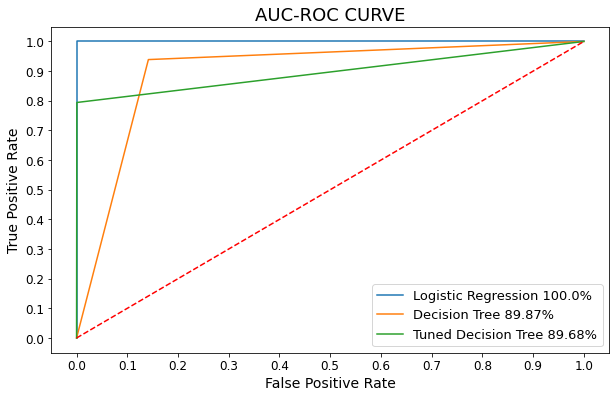

In [186]:
auc_value,fpr,tpr = AUC_value(prediction)
plot(fpr, tpr, auc_value)

In [188]:
result

,Overall Accuracy,Precision Value,Recall Value,F1-Score,Type I Error,Type II Error,Total Error
Algorithm_Use,,,,,,,
Logistic Regression,0.9998,1,0.7942,0.8853,0,64,64
Decision Tree,0.8585,0.008,0.9389,0.0158,36341,19,36360
Tuned Decision Tree,0.9992,0.6333,0.7942,0.7047,143,64,207
Random Forest,0.9015,0.0118,0.9743,0.0234,25302,8,25310
Tuned Random Forest,0.9678,0.0298,0.8135,0.0576,8227,58,8285
KNN,0.9991,0.6693,0.5466,0.6018,84,141,225
SVC,0.9994,0.7352,0.7588,0.7468,85,75,160
XG Boost,0.8348,0.0069,0.9453,0.0137,42442,17,42459
